<a href="https://colab.research.google.com/github/Amoor-11/mynewrepo/blob/main/LIP_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nicknochnack/LipNet.git

Cloning into 'LipNet'...
remote: Enumerating objects: 32, done.
remote: Total 32 (delta 0), reused 0 (delta 0), pack-reused 32 (from 1)
Receiving objects: 100% (32/32), 180.84 MiB | 19.56 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
!pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.12.0
anywidget                           

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [4]:
import gdown

In [5]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=4853c10f-328e-4a56-964f-225c585661ab
To: /content/data.zip
100%|██████████| 423M/423M [00:06<00:00, 66.7MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [6]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [9]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [46]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [15]:
tf.convert_to_tensor('data\\s1\\bbal6n.mpg').numpy().decode('utf-8').split('\\')[-1]

'bbal6n.mpg'

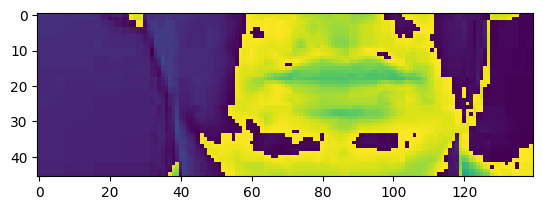

In [25]:
frame, alignment = load_data(tf.convert_to_tensor('.data\\s1\\bbal6n.mpg'))
plt.imshow(frame[0])

In [30]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [51]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [56]:
sample = data.as_numpy_iterator()

TypeError: 'NumpyIterator' object is not subscriptable

In [58]:
val = sample.next(); val[0]

array([[[[[1.380147  ],
          [1.380147  ],
          [1.3418095 ],
          ...,
          [0.11501224],
          [0.07667483],
          [0.07667483]],

         [[1.380147  ],
          [1.380147  ],
          [1.3418095 ],
          ...,
          [0.11501224],
          [0.07667483],
          [0.07667483]],

         [[1.4568218 ],
          [1.4568218 ],
          [1.4568218 ],
          ...,
          [0.03833742],
          [0.03833742],
          [0.03833742]],

         ...,

         [[0.9967728 ],
          [0.9967728 ],
          [0.95843536],
          ...,
          [9.507679  ],
          [9.507679  ],
          [9.507679  ]],

         [[0.9967728 ],
          [0.9967728 ],
          [0.95843536],
          ...,
          [9.507679  ],
          [9.507679  ],
          [9.507679  ]],

         [[0.9967728 ],
          [0.9967728 ],
          [0.95843536],
          ...,
          [9.507679  ],
          [9.507679  ],
          [9.507679  ]]],


        [[[1.4184

In [62]:
imageio.mimsave('./animation.gif', val[0], fps=10)

TypeError: Cannot handle this data type: (1, 1, 140, 1), <f4